In [1]:
!pip install plotly

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import plotly.express as px

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [0]:
df = pd.read_csv('listings_summary.csv')

In [4]:
df.shape

(22552, 96)

In [5]:
df.duplicated().sum()

0

In [6]:
df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,...,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,NaN,Within walking distance you'll find the S-Bahn...,Außer deinem Zimmer kannst du noch die Küche u...,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/97d4f6e8-1...,NaN,2986,https://www.airbnb.com/users/show/2986,Michael,2008-09-16,"Berlin, Berlin, Germany",Living with my wife in Berlin. Like travellin...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/50434955-1...,https://a0.muscache.com/im/pictures/50434955-1...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",NaN,Prenzlauer Berg Nordwest,...,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",NaN,$17.00,NaN,NaN,$0.00,$0.00,1,$0.00,2,40,7 weeks ago,t,0,0,0,0,2018-11-07,6,2018-07-04,2018-10-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,NaN,f,f,flexible,f,f,1,1.42


In [0]:
col = df.columns

In [8]:
col

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [9]:
df[['summary','description']].isnull().sum()

summary        963
description    203
dtype: int64

In [10]:
df[['summary','description']].head()

,summary,description
0,Great location! 30 of 75 sq meters. This wood...,Great location! 30 of 75 sq meters. This wood...
1,NaN,In the summertime we are spending most of our ...
2,This beautiful first floor apartment is situa...,This beautiful first floor apartment is situa...
3,First of all: I prefer short-notice bookings. ...,First of all: I prefer short-notice bookings. ...
4,Cozy and large room in the beautiful district ...,Cozy and large room in the beautiful district ...


In [11]:
df['cancellation_policy'].head()

0    strict_14_with_grace_period
1                       flexible
2    strict_14_with_grace_period
3    strict_14_with_grace_period
4                       moderate
Name: cancellation_policy, dtype: object

In [0]:
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

In [0]:
df_raw = df[columns_to_keep].set_index('id')

In [0]:
df_raw.shape

(22552, 23)

### room types?

In [0]:
df_raw.room_type.value_counts(normalize=True)

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

### property types

In [0]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Camper/RV                 0.000488
Houseboat                 0.000488
Villa                     0.000443
Aparthotel                0.000310
Pension (South Korea)     0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Casa particular (Cuba)    0.000089
Train                     0.000089
Castle                    0.000089
Cave                      0.000044
Chalet              

### cleaning price columns

In [0]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


### checking for null values in the price columns

In [0]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].isnull().sum()

price                  0
cleaning_fee        7146
extra_people           0
security_deposit    9361
dtype: int64

cleaning fee
There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

security deposit
same for the security deposit as well. 

In [0]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.security_deposit.fillna('$0.00', inplace=True)

In [0]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].isnull().sum()

price               0
cleaning_fee        0
extra_people        0
security_deposit    0
dtype: int64

Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

In [0]:
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [0]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].dtypes

price               float64
cleaning_fee        float64
extra_people        float64
security_deposit    float64
dtype: object

In [0]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

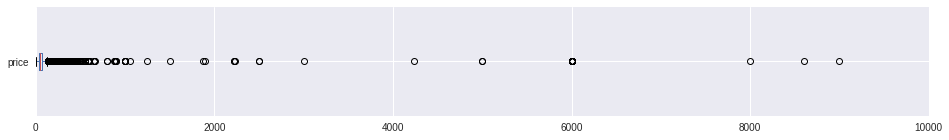

In [0]:
df_raw['price'].plot(kind='box', xlim=(0, 10000), vert=False,  figsize=(16,2));

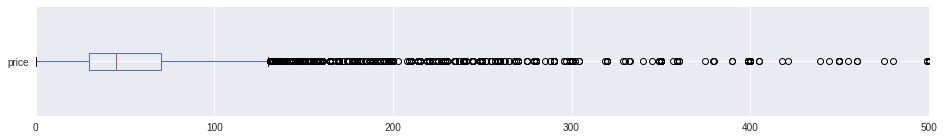

In [0]:
df_raw['price'].plot(kind='box', xlim=(0, 500), vert=False,  figsize=(16,2));

A bit messy, as expected!

75% of the apartments charge up to 68€ - but the maximum value is 9000€. Let's decide on a limit of 300€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [0]:
df_raw = df_raw[(df_raw['price'] > 7 )& (df_raw['price'] <= 300)]

In [0]:
df_raw['price'].describe()

count    22378.000000
mean        56.739789
std         38.989867
min          8.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        300.000000
Name: price, dtype: float64

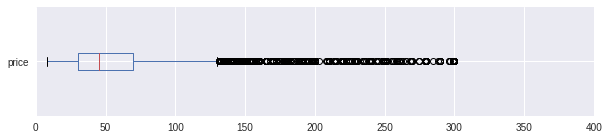

In [0]:
df_raw['price'].plot(kind='box', xlim=(0, 400), vert=False,  figsize=(10,2));

### dealing with the missing values

In [0]:
df_raw.isnull().sum()

space                            8485
description                       201
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21934
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [0]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [0]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [0]:
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [0]:
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [0]:
df_raw.isna().sum()

description                     201
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [0]:
df_raw.shape

(22328, 21)

In [0]:
df_raw=df_raw.dropna()

In [0]:
df_raw.shape

(22127, 21)

### Feature Engg lodging amenities

In [0]:
from collections import Counter
results = Counter()
df_raw['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 21125),
 ('Kitchen', 20967),
 ('Heating', 20832),
 ('Essentials', 19970),
 ('Washer', 18175),
 ('Hair dryer', 14636),
 ('Laptop friendly workspace', 14198),
 ('Hangers', 13640),
 ('Iron', 10983),
 ('Shampoo', 10438),
 ('TV', 9890),
 ('Hot water', 9529),
 ('Family/kid friendly', 8046),
 ('Internet', 7837),
 ('Host greets you', 6576),
 ('Smoke detector', 6303),
 ('Buzzer/wireless intercom', 6058),
 ('Lock on bedroom door', 5179),
 ('Refrigerator', 5122),
 ('Free street parking', 5120),
 ('Dishes and silverware', 4997),
 ('Cooking basics', 4756),
 ('Bed linens', 4755),
 ('Stove', 4730),
 ('Elevator', 4725),
 ('Smoking allowed', 4504),
 ('Oven', 4234),
 ('translation missing: en.hosting_amenity_50', 4163),
 ('First aid kit', 3910),
 ('Cable TV', 3644)]

In [0]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

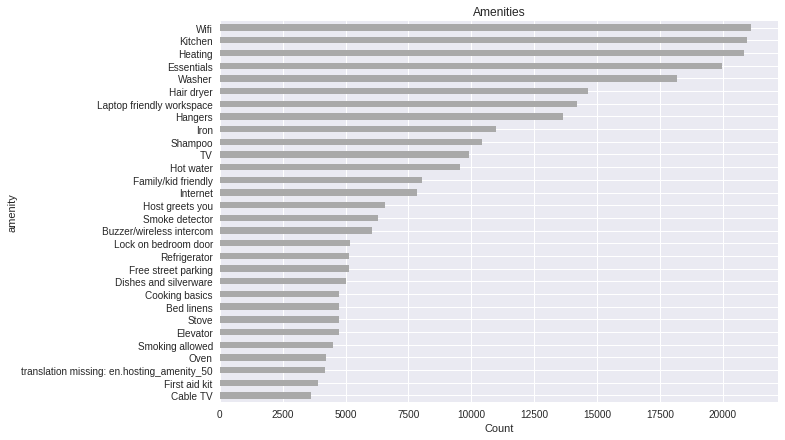

In [0]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Let's add columns with amenities that are somewhat unique and not offered by all hosts:

a laptop-friendly workspace
a TV
kid friendly accommodation
smoker friendly and
being greeted by the host.

Also add Wifi as feature to select

After doing this, let's drop the original column:

In [0]:
df = df_raw

In [0]:
df['Wifi'] = df['amenities'].str.contains('Wifi')
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')


In [0]:
df.drop(['amenities'], axis=1, inplace=True)

### Explotory data analysis

#### Price Differences on a Map

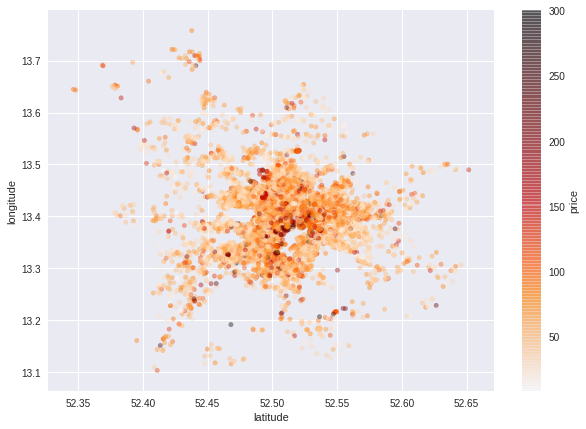

In [0]:
df.plot(kind="scatter",x="latitude", y="longitude",  alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

 ### Price Differences by Neighbourhood

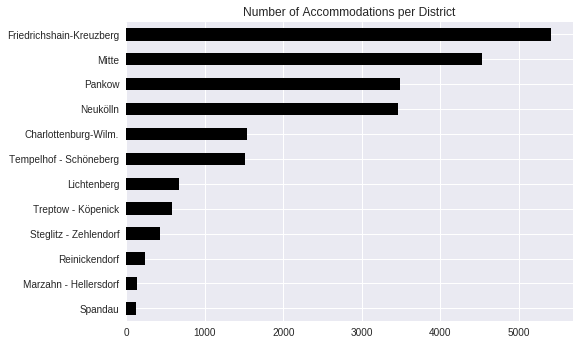

In [0]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='black')
plt.title('Number of Accommodations per District');

In [0]:

fig = px.scatter(df, x='latitude', y='longitude', color='neighbourhood_group_cleansed',
                hover_data=['room_type', 'neighbourhood_group_cleansed', 'minimum_nights', 'price'])
fig.show()

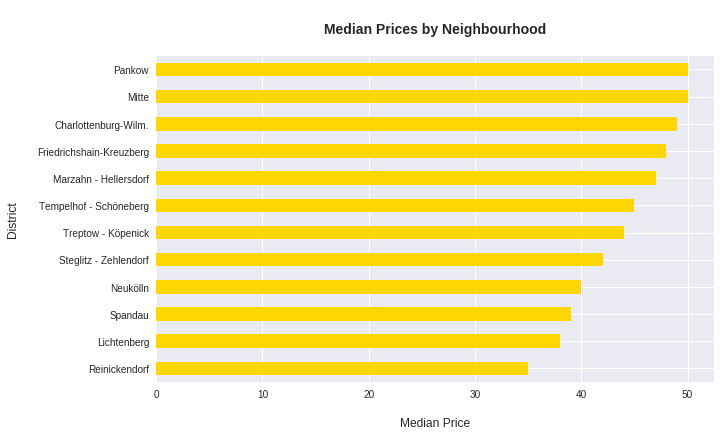

In [0]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='gold')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

### Price Differences by Number of Bedrooms

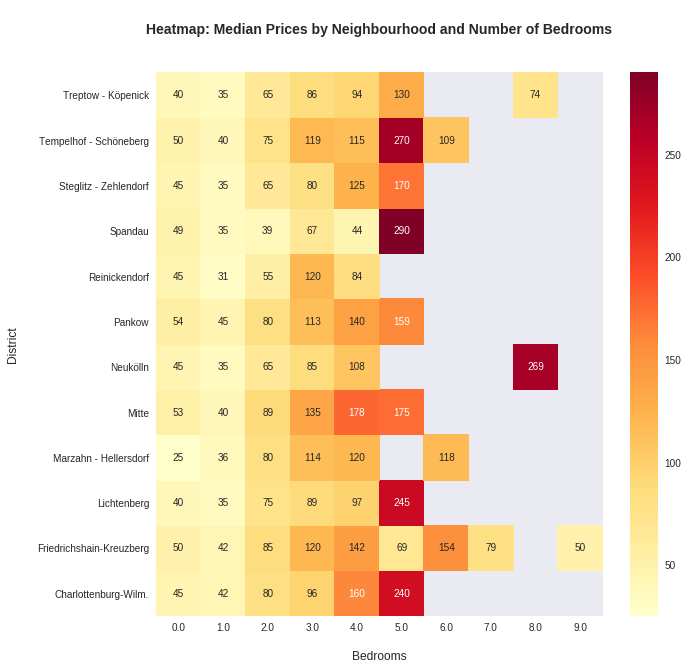

In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='YlOrRd',annot=True, fmt=".0f")
plt.ylim(0,12)
plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

### Price Differences by Cancellation Policy

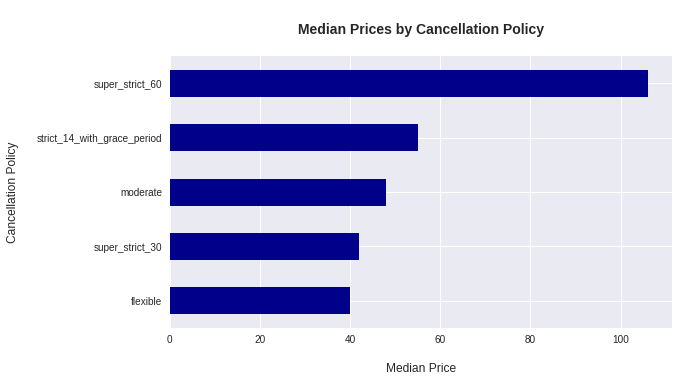

In [0]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');